In [1]:
import pandas as pd
from datetime import datetime
import sklearn
from sklearn.datasets import load_diabetes
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('C:/Users/mloai/Event-Aware Sales Forecasting with Time Series Models/sales_marketing.csv')

In [3]:
# Step 1: Fix and validate CAL_DATE (Gregorian)
df['CAL_DATE'] = pd.to_datetime(df['CAL_DATE'], errors='coerce')  # Converts invalid formats to NaT
df = df.dropna(subset=['CAL_DATE'])  # Drop rows where CAL_DATE couldn't be parsed
df = df[df['CAL_DATE'] <= pd.to_datetime(datetime.today())]  # Optional: drop future dates

In [4]:
df['Category_Channel'] = df['CATEGORY_CODE'].astype(str) + '_' + df['CHANNEL_NAME']

In [5]:
# Step 3: Validate HIJRI_DATE (Islamic)
df['HIJRI_DATE'] = df['HIJRI_DATE'].astype(str)
df = df[df['HIJRI_DATE'].str.len() == 10]

# Extract Hijri month and day for tagging holidays
df['HIJRI_MONTH'] = df['HIJRI_DATE'].str[5:7]
df['HIJRI_DAY'] = df['HIJRI_DATE'].str[8:10]

valid_months = [f'{i:02}' for i in range(1, 13)]
valid_days = [f'{i:02}' for i in range(1, 31)]

df = df[df['HIJRI_MONTH'].isin(valid_months)]
df = df[df['HIJRI_DAY'].isin(valid_days)]

In [6]:
df['Main Event'] = df['Main Event'].fillna('Regular')
df['Main Event'] = df['Main Event'].replace('', 'Regular')  # In case of empty strings

In [7]:
# Tag Ramadan
df['Is_Ramadan'] = (df['HIJRI_MONTH'] == '09').astype(int)

# Tag Eid al-Fitr (1st of Shawwal)
df['Is_Eid_Fitr'] = ((df['HIJRI_MONTH'] == '10') & (df['HIJRI_DAY'] == '01')).astype(int)

# Tag Eid al-Adha (10th of Dhu al-Hijjah)
df['Is_Eid_Adha'] = ((df['HIJRI_MONTH'] == '12') & (df['HIJRI_DAY'] == '10')).astype(int)


In [8]:
df.head()

,CAL_YEAR,CAL_DATE,HIJRI_DATE,CATEGORY_CODE,CATEGORY_DESC,CHANNEL_NAME,SALES_AMOUNT,Main Event,Category_Channel,HIJRI_MONTH,HIJRI_DAY,Is_Ramadan,Is_Eid_Fitr,Is_Eid_Adha
0,2022,2022-01-01,1443-05-28,1,ELECTRONICS,Brick and Mortar,1.449489e+06,End Of Year,1_Brick and Mortar,05,28,0,0,0
1,2022,2022-01-01,1443-05-28,102,MUSICAL INSTRUMENTS,Brick and Mortar,5.208700e+03,End Of Year,102_Brick and Mortar,05,28,0,0,0
2,2022,2022-01-01,1443-05-28,102,MUSICAL INSTRUMENTS,E-Commerce,2.141739e+03,End Of Year,102_E-Commerce,05,28,0,0,0
3,2022,2022-01-01,1443-05-28,102,MUSICAL INSTRUMENTS,Noon,3.900000e+03,End Of Year,102_Noon,05,28,0,0,0
4,2022,2022-01-01,1443-05-28,105,HOME AUTOMATION,Brick and Mortar,6.036184e+04,End Of Year,105_Brick and Mortar,05,28,0,0,0


In [9]:
df_cleaned = df[df['SALES_AMOUNT'] > 1000]    

In [10]:
print("Before:", len(df))
print("After :", len(df_cleaned))
print("Removed:", len(df) - len(df_cleaned))


Before: 51973
After : 41551
Removed: 10422


C:\Users\mloai\AppData\Local\Temp\ipykernel_15884\3865393087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['LOG_SALES'] = np.log1p(df_cleaned['SALES_AMOUNT'])


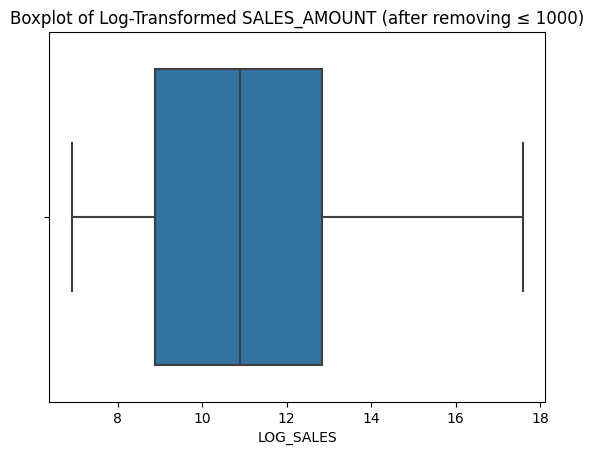

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: apply log transform again
import numpy as np
df_cleaned['LOG_SALES'] = np.log1p(df_cleaned['SALES_AMOUNT'])

# Plot boxplot after cleaning
sns.boxplot(x=df_cleaned['LOG_SALES'])
plt.title("Boxplot of Log-Transformed SALES_AMOUNT (after removing ≤ 1000)")
plt.show()


C:\Users\mloai\NewConda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


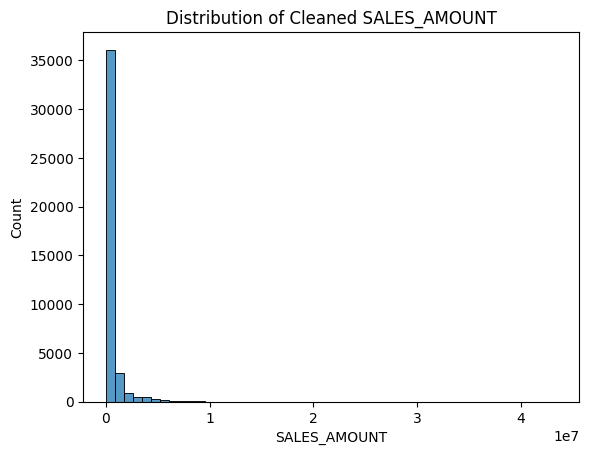

In [12]:
sns.histplot(df_cleaned['SALES_AMOUNT'], bins=50)
plt.title("Distribution of Cleaned SALES_AMOUNT")
plt.show()


In [13]:
df_cleaned[df_cleaned['SALES_AMOUNT'] == 0]

,CAL_YEAR,CAL_DATE,HIJRI_DATE,CATEGORY_CODE,CATEGORY_DESC,CHANNEL_NAME,SALES_AMOUNT,Main Event,Category_Channel,HIJRI_MONTH,HIJRI_DAY,Is_Ramadan,Is_Eid_Fitr,Is_Eid_Adha,LOG_SALES


In [14]:
df_cleaned.duplicated().sum()


0

In [15]:
df_cleaned.isnull().sum()


CAL_YEAR            0
CAL_DATE            0
HIJRI_DATE          0
CATEGORY_CODE       0
CATEGORY_DESC       0
CHANNEL_NAME        0
SALES_AMOUNT        0
Main Event          0
Category_Channel    0
HIJRI_MONTH         0
HIJRI_DAY           0
Is_Ramadan          0
Is_Eid_Fitr         0
Is_Eid_Adha         0
LOG_SALES           0
dtype: int64

In [16]:
df_cleaned['CAL_DATE'].sort_values().diff().value_counts()


CAL_DATE
0 days    40310
1 days     1240
Name: count, dtype: int64

In [17]:
df_cleaned.head()

,CAL_YEAR,CAL_DATE,HIJRI_DATE,CATEGORY_CODE,CATEGORY_DESC,CHANNEL_NAME,SALES_AMOUNT,Main Event,Category_Channel,HIJRI_MONTH,HIJRI_DAY,Is_Ramadan,Is_Eid_Fitr,Is_Eid_Adha,LOG_SALES
0,2022,2022-01-01,1443-05-28,1,ELECTRONICS,Brick and Mortar,1.449489e+06,End Of Year,1_Brick and Mortar,05,28,0,0,0,14.186722
1,2022,2022-01-01,1443-05-28,102,MUSICAL INSTRUMENTS,Brick and Mortar,5.208700e+03,End Of Year,102_Brick and Mortar,05,28,0,0,0,8.558278
2,2022,2022-01-01,1443-05-28,102,MUSICAL INSTRUMENTS,E-Commerce,2.141739e+03,End Of Year,102_E-Commerce,05,28,0,0,0,7.669840
3,2022,2022-01-01,1443-05-28,102,MUSICAL INSTRUMENTS,Noon,3.900000e+03,End Of Year,102_Noon,05,28,0,0,0,8.268988
4,2022,2022-01-01,1443-05-28,105,HOME AUTOMATION,Brick and Mortar,6.036184e+04,End Of Year,105_Brick and Mortar,05,28,0,0,0,11.008129


In [18]:
# Step 5: Group by CAL_DATE, CATEGORY_DESC, CHANNEL_NAME, and Main Event
group_cols = ['CAL_DATE','HIJRI_DATE', 'Main Event','Category_Channel']
df_grouped = df_cleaned.groupby(group_cols, as_index=False)['LOG_SALES'].sum()

In [19]:
df_grouped.head()

,CAL_DATE,HIJRI_DATE,Main Event,Category_Channel,LOG_SALES
0,2022-01-01,1443-05-28,End Of Year,102_Brick and Mortar,8.558278
1,2022-01-01,1443-05-28,End Of Year,102_E-Commerce,7.669840
2,2022-01-01,1443-05-28,End Of Year,102_Noon,8.268988
3,2022-01-01,1443-05-28,End Of Year,105_Brick and Mortar,11.008129
4,2022-01-01,1443-05-28,End Of Year,105_E-Commerce,10.310405


In [20]:
# Step 6: Merge holiday flags back into grouped data
holiday_flags = df_cleaned[['CAL_DATE', 'Is_Ramadan', 'Is_Eid_Fitr', 'Is_Eid_Adha']].drop_duplicates()
df_final = pd.merge(df_grouped, holiday_flags, on='CAL_DATE', how='left')

In [21]:
# Step 7: Export processed file
df_final.to_csv("processed_sales.csv", index=False)

print("✅ Preprocessing complete. Output saved as 'processed_sales.csv'")

✅ Preprocessing complete. Output saved as 'processed_sales.csv'
